In [ ]:
##importing Basic libraries
import pandas as pd
import pickle
from pandas import DataFrame, Series
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
import numpy as np
import seaborn as sns
from sklearn import linear_model, naive_bayes
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeRegressor
from sklearn import svm
from matplotlib import pyplot
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error,r2_score
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objects as go
import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam


In [186]:
df3 = pd.read_csv("2025.csv",low_memory=False)

In [188]:
#Create a new dataframe with only the columns we want for Analysis
dft = df3[['Pitcher','PitcherTeam','TaggedPitchType','PitchCall','PlayResult','RelSpeed','SpinRate','RelHeight','RelSide','Extension','InducedVertBreak', 'HorzBreak','PlateLocHeight','PlateLocSide']]

In [189]:
#fastballs = 'Fastball', 'Sinker', 'TwoSeamFastBall', 'FourSeamFastBall', 'OneSeamFastBall'
dfb2 = dft[dft.TaggedPitchType.isin(['Fastball', 'Sinker', 'TwoSeamFastBall', 'FourSeamFastBall', 'OneSeamFastBall'])]
#sliders = 'Slider'
dsl2 = dft[dft.TaggedPitchType.isin(['Slider'])]
#curveballs = 'Curveball', 'KnuckleCurve'
dcb2 = dft[dft.TaggedPitchType.isin(['Curveball', 'KnuckleCurve'])]
#changeups = 'Changeup', 'Splitter', 'Forkball', 'Screwball'
dch2 = dft[dft.TaggedPitchType.isin(['ChangeUp'])]



In [190]:
#create a new column called ABS_Horizontal with the absolute value of HorzBreak  in dfb2
dfb2['ABS_Horizontal'] = abs(dfb2['HorzBreak'])
dsl2['ABS_Horizontal'] = abs(dsl2['HorzBreak'])
dcb2['ABS_Horizontal'] = abs(dcb2['HorzBreak'])
dch2['ABS_Horizontal'] = abs(dch2['HorzBreak'])
#create a new column called ABS_relside with the absolute value of RelSide in dfb2
dfb2['ABS_RelSide'] = abs(dfb2['RelSide'])
dsl2['ABS_RelSide'] = abs(dsl2['RelSide'])
dcb2['ABS_RelSide'] = abs(dcb2['RelSide'])
dch2['ABS_RelSide'] = abs(dch2['RelSide'])
#create a new column called differential break which is the absolute value of InducedVertBreak - ABS_Horizontal
dfb2['differential_break'] = abs(dfb2['InducedVertBreak'] - dfb2['ABS_Horizontal'])
dsl2['differential_break'] = abs(dsl2['InducedVertBreak'] - dsl2['ABS_Horizontal'])
dcb2['differential_break'] = abs(dcb2['InducedVertBreak'] - dcb2['ABS_Horizontal'])
dch2['differential_break'] = abs(dch2['InducedVertBreak'] - dch2['ABS_Horizontal'])


C:\Users\maxim\AppData\Local\Temp\ipykernel_15552\3249499381.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\maxim\AppData\Local\Temp\ipykernel_15552\3249499381.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\maxim\AppData\Local\Temp\ipykernel_15552\3249499381.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

In [191]:
#delete all rows with nan values
dfb2 = dfb2.dropna()
dsl2 = dsl2.dropna()
dcb2 = dcb2.dropna()
dch2 = dch2.dropna()


In [192]:
#reset index    
dfb2 = dfb2.reset_index(drop=True)
dsl2 = dsl2.reset_index(drop=True)
dcb2 = dcb2.reset_index(drop=True)
dch2 = dch2.reset_index(drop=True)

In [193]:
#PitchCall unique values
dft['PitchCall'].unique()

array(['BallCalled', 'StrikeCalled', 'StrikeSwinging', 'InPlay',
       'HitByPitch', 'FoulBallNotFieldable', 'BallinDirt', 'Undefined',
       'FoulBallFieldable', 'Foul', 'FoulTip', nan], dtype=object)

In [194]:
#change 'SwinginStrike', 'StriekSwinging' in PitchCall to 'StrikeSwinging'
dft['PitchCall'] = dft['PitchCall'].replace(['SwinginStrike', 'StriekSwinging'], 'StrikeSwinging')

C:\Users\maxim\AppData\Local\Temp\ipykernel_15552\2683645860.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [195]:
#new dataframe with only PitchCall StrikeSwinging, InPlay, FoulBall and call it df_Swing
df_Swing = dft[(dft['PitchCall'] == 'StrikeSwinging') | (dft['PitchCall'] == 'InPlay') | (dft['PitchCall'] == 'FoulBall')]

In [196]:
#create a dummy variable for PitchCall with StrikeSwinging = 1 and InPlay, FoulBall = 0
df_Swing['Whiff'] = df_Swing['PitchCall'].replace(['StrikeSwinging'], 1)
df_Swing['Whiff'] = df_Swing['PitchCall'].replace(['InPlay', 'FoulBall'], 0)

C:\Users\maxim\AppData\Local\Temp\ipykernel_15552\2116572367.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\maxim\AppData\Local\Temp\ipykernel_15552\2116572367.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [197]:
#replace strike swinging with 1 and inplay, foulball with 0
df_Swing['Whiff'] = df_Swing['Whiff'].replace(['StrikeSwinging'], 1)

C:\Users\maxim\AppData\Local\Temp\ipykernel_15552\2166355664.py:2: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

C:\Users\maxim\AppData\Local\Temp\ipykernel_15552\2166355664.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [198]:
#create a new column called ABS_Horizontal with the absolute value of HorzBreak
df_Swing['ABS_Horizontal'] = abs(df_Swing['HorzBreak'])
#create a new column called ABS_RelSide with the absolute value of RelSide
df_Swing['ABS_RelSide'] = abs(df_Swing['RelSide'])

C:\Users\maxim\AppData\Local\Temp\ipykernel_15552\1567009961.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\maxim\AppData\Local\Temp\ipykernel_15552\1567009961.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [199]:
#create a new column called differential break which is the absolute value of InducedVertBreak - ABS_Horizontal
df_Swing['differential_break'] = abs(df_Swing['InducedVertBreak'] - df_Swing['ABS_Horizontal'])

C:\Users\maxim\AppData\Local\Temp\ipykernel_15552\2720128996.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [200]:
#taggedpitchtype unique values
df_Swing['TaggedPitchType'].unique()

array(['FourSeamFastBall', 'ChangeUp', 'Fastball', 'Slider', 'Cutter',
       'Curveball', 'OneSeamFastBall', 'TwoSeamFastBall', 'Splitter',
       'Sinker', 'Changeup', 'Undefined'], dtype=object)

In [201]:
#remove any row with Nan for any of the columns
df_Swing = df_Swing.dropna()
#reset the index
df_Swing = df_Swing.reset_index(drop=True)

In [202]:
#seperate dataframes for each pitch type 
#fastballs = 'Fastball', 'Sinker', 'TwoSeamFastBall', 'FourSeamFastBall', 'OneSeamFastBall'
df_Fastball = df_Swing[(df_Swing['TaggedPitchType'] == 'Fastball') | (df_Swing['TaggedPitchType'] == 'Sinker') | (df_Swing['TaggedPitchType'] == 'TwoSeamFastBall') | (df_Swing['TaggedPitchType'] == 'FourSeamFastBall') | (df_Swing['TaggedPitchType'] == 'OneSeamFastBall')]
df_Fastball = df_Fastball.reset_index(drop=True)

In [203]:
#curveballs = 'Curveball', 'KnuckleCurve'
df_Curveball = df_Swing[(df_Swing['TaggedPitchType'] == 'Curveball') | (df_Swing['TaggedPitchType'] == 'KnuckleCurve')]
df_Curveball = df_Curveball.reset_index(drop=True)

In [204]:
#df_Slider = 'Slider'
df_Slider = df_Swing[(df_Swing['TaggedPitchType'] == 'Slider')]
df_Slider = df_Slider.reset_index(drop=True)

In [205]:
#df_Changeup = 'Changeup'
df_Changeup = df_Swing[(df_Swing['TaggedPitchType'] == 'ChangeUp')]
df_Changeup = df_Changeup.reset_index(drop=True)

In [206]:
df_Swing.columns

Index(['Pitcher', 'PitcherTeam', 'TaggedPitchType', 'PitchCall', 'PlayResult',
       'RelSpeed', 'SpinRate', 'RelHeight', 'RelSide', 'Extension',
       'InducedVertBreak', 'HorzBreak', 'PlateLocHeight', 'PlateLocSide',
       'Whiff', 'ABS_Horizontal', 'ABS_RelSide', 'differential_break'],
      dtype='object')

In [207]:
#create the FB expected whiff rate
X = df_Fastball[['RelSpeed', 'SpinRate','differential_break','RelHeight', 'ABS_RelSide', 'Extension']]
y = df_Fastball['Whiff']

In [208]:
#create the CB expected whiff rate
X1 = df_Curveball[['RelSpeed', 'SpinRate', 'InducedVertBreak', 'ABS_Horizontal','RelHeight', 'ABS_RelSide', 'Extension']]
y1 = df_Curveball['Whiff']

In [209]:
#create the SL expected whiff rate
X2 = df_Slider[['RelSpeed', 'SpinRate', 'InducedVertBreak', 'ABS_Horizontal','RelHeight', 'ABS_RelSide', 'Extension']]
y2 = df_Slider['Whiff']

In [210]:
#create the CH expected whiff rate
X3 = df_Changeup[['RelSpeed', 'SpinRate', 'InducedVertBreak', 'ABS_Horizontal','RelHeight', 'ABS_RelSide', 'Extension']]
y3 = df_Changeup['Whiff']

In [211]:
#split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.25, random_state=101)

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.25, random_state=101)

X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.25, random_state=101)



In [212]:
def train_model(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Create the neural network model
    model = Sequential()
    model.add(Dense(64, input_dim=X.shape[1], activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

    # Train the model
    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32)

    return model

In [213]:
#xgboost for fastball
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [214]:
#random forest for fastball
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train)

RandomForestClassifier()

In [215]:
fastball_model = train_model(X, y)

Epoch 1/50


c:\Users\maxim\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6369 - loss: 57.1888 - val_accuracy: 0.6768 - val_loss: 0.7224
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5718 - loss: 3.7157 - val_accuracy: 0.6768 - val_loss: 3.0089
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6866 - loss: 2.9256 - val_accuracy: 0.6768 - val_loss: 3.5079
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6411 - loss: 1.7003 - val_accuracy: 0.6768 - val_loss: 0.8252
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6456 - loss: 0.8572 - val_accuracy: 0.6768 - val_loss: 3.3517
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6176 - loss: 1.7651 - val_accuracy: 0.6768 - val_loss: 1.1062
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6111 - loss: 1.7830 - val_accuracy: 0.6768 - val_loss: 2.1976
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6459 - loss: 1.1579 - val_accuracy: 0.6768 - val_loss: 0.7114
Ep

In [217]:
#xgboost for curveball
xgb_model1 = XGBClassifier()
xgb_model1.fit(X1_train, y1_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [218]:
#random forest for curveball
rfc1 = RandomForestClassifier(n_estimators=100)
rfc1.fit(X1_train, y1_train)

RandomForestClassifier()

In [219]:
#CURVEBALL MODEL
curveball_model = train_model(X1, y1)

Epoch 1/50


c:\Users\maxim\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.6468 - loss: 64.4765 - val_accuracy: 0.6061 - val_loss: 3.2326
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5276 - loss: 17.6527 - val_accuracy: 0.3939 - val_loss: 21.4083
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4423 - loss: 14.7768 - val_accuracy: 0.6061 - val_loss: 22.4359
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6672 - loss: 21.3384 - val_accuracy: 0.6061 - val_loss: 20.0141
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6499 - loss: 13.9533 - val_accuracy: 0.3939 - val_loss: 7.8425
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3717 - loss: 8.0012 - val_accuracy: 0.6061 - val_loss: 9.1538
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6147 - loss: 10.6362 - val_accuracy: 0.6061 - val_loss: 7.5410
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5529 - loss: 5.6753 - val_accuracy: 0.3939 - val_loss: 1.8555
Epoc

In [220]:
#xgboost for slider
xgb_model2 = XGBClassifier()
xgb_model2.fit(X2_train, y2_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [221]:
#random forest for slider
rfc2 = RandomForestClassifier(n_estimators=100)
rfc2.fit(X2_train, y2_train)


RandomForestClassifier()

In [222]:
#SLIDER MODEL
slider_model = train_model(X2, y2)

Epoch 1/50


c:\Users\maxim\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5136 - loss: 35.8298 - val_accuracy: 0.5839 - val_loss: 3.4539
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5415 - loss: 2.6888 - val_accuracy: 0.5839 - val_loss: 1.7815
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5395 - loss: 1.9136 - val_accuracy: 0.4161 - val_loss: 1.7032
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5192 - loss: 1.5568 - val_accuracy: 0.4161 - val_loss: 3.9418
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5210 - loss: 2.9312 - val_accuracy: 0.5235 - val_loss: 0.8832
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5092 - loss: 0.9576 - val_accuracy: 0.4228 - val_loss: 1.0027
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5077 - loss: 1.0358 - val_accuracy: 0.4161 - val_loss: 3.5486
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5299 - loss: 2.1551 - val_accuracy: 0.4094 - val_loss: 1.2637
E

In [223]:
#xgboost for changeup
xgb_model3 = XGBClassifier()
xgb_model3.fit(X3_train, y3_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [224]:
#random forest for changeup
rfc3 = RandomForestClassifier(n_estimators=100)
rfc3.fit(X3_train, y3_train)

RandomForestClassifier()

In [225]:
#CHANGEUP MODEL
changeup_model = train_model(X3, y3)

Epoch 1/50


c:\Users\maxim\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.4631 - loss: 43.4452 - val_accuracy: 0.5185 - val_loss: 34.8164
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5866 - loss: 24.7951 - val_accuracy: 0.4815 - val_loss: 9.3816
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4437 - loss: 17.0025 - val_accuracy: 0.5185 - val_loss: 2.0806
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6050 - loss: 7.0305 - val_accuracy: 0.5185 - val_loss: 1.9639
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5067 - loss: 5.5828 - val_accuracy: 0.5185 - val_loss: 5.3630
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5988 - loss: 6.6309 - val_accuracy: 0.4815 - val_loss: 5.0411
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4333 - loss: 6.2588 - val_accuracy: 0.5185 - val_loss: 4.3203
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5379 - loss: 2.8820 - val_accuracy: 0.5185 - val_loss: 3.8174
Epoch 9/50
7/

In [226]:
#find rmse for fastball
predictions = xgb_model.predict(X_test)
print('XGBoost Fastball RMSE:', np.sqrt(mean_squared_error(y_test, predictions)))

XGBoost Fastball RMSE: 0.5457768229098153


In [227]:
#find rmse for fastball
predictions = rfc.predict(X_test)
print('Random Forest Fastball RMSE:', np.sqrt(mean_squared_error(y_test, predictions)))

Random Forest Fastball RMSE: 0.4774552605594227


In [228]:
#find rmse for Fastball nn
predictions = fastball_model.predict(X_test)
print('Neural Network Fastball RMSE:', np.sqrt(mean_squared_error(y_test, predictions)))

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Neural Network Fastball RMSE: 0.6006566771423179


In [229]:
#create a new column in the dfb2 dataframe called xWhiff_xg and set it equal to the predicted probability of a whiff as predicted by the xgboost model
dfb2['xWhiff_xg'] = xgb_model.predict_proba(dfb2[['RelSpeed', 'SpinRate', 'differential_break', 'RelHeight', 'ABS_RelSide', 'Extension']])[:,1]


In [230]:
#create a new column in the dfb2 dataframe called xWhiff_xg and set it equal to the predicted probability of a whiff as predicted by the xgboost model
dcb2['xWhiff_xg'] = xgb_model1.predict_proba(dcb2[['RelSpeed', 'SpinRate', 'InducedVertBreak', 'ABS_Horizontal','RelHeight', 'ABS_RelSide', 'Extension']])[:,1]

In [231]:
#create a new column in the dsl2 dataframe called xWhiff and use the model tp predict the expected whiff rate given the same variables
dsl2['xWhiff_xg'] = xgb_model2.predict_proba(dsl2[['RelSpeed', 'SpinRate', 'InducedVertBreak', 'ABS_Horizontal','RelHeight', 'ABS_RelSide', 'Extension']])[:,1]

In [232]:
#create a new column in the dch2 dataframe called xWhiff and use the model tp predict the expected whiff rate given the same variables
dch2['xWhiff_xg'] = xgb_model3.predict_proba(dch2[['RelSpeed', 'SpinRate', 'InducedVertBreak', 'ABS_Horizontal','RelHeight', 'ABS_RelSide', 'Extension']])[:,1]

In [233]:
#create a new column in the dfb2 dataframe called xWhiff_rf and set it equal to the predicted probability of a whiff as predicted by the random forest model
dfb2['xWhiff_rf'] = rfc.predict_proba(dfb2[['RelSpeed', 'SpinRate', 'differential_break', 'RelHeight', 'ABS_RelSide', 'Extension']])[:,1]


In [234]:
#create a new column in the dfb2 dataframe called xWhiff_rf and set it equal to the predicted probability of a whiff as predicted by the random forest model
dcb2['xWhiff_rf'] = rfc1.predict_proba(dcb2[['RelSpeed', 'SpinRate', 'InducedVertBreak', 'ABS_Horizontal','RelHeight', 'ABS_RelSide', 'Extension']])[:,1]

In [235]:
#create a new column in the dsl2 dataframe called xWhiff and use the model tp predict the expected whiff rate given the same variables
dsl2['xWhiff_rf'] = rfc2.predict_proba(dsl2[['RelSpeed', 'SpinRate', 'InducedVertBreak', 'ABS_Horizontal','RelHeight', 'ABS_RelSide', 'Extension']])[:,1]

In [236]:
#create a new column in the dch2 dataframe called xWhiff and use the model tp predict the expected whiff rate given the same variables
dch2['xWhiff_rf'] = rfc3.predict_proba(dch2[['RelSpeed', 'SpinRate', 'InducedVertBreak', 'ABS_Horizontal','RelHeight', 'ABS_RelSide', 'Extension']])[:,1]

In [237]:
#USE NEURAL NETWORK TO PREDICT WHIFF RATE FOR FASTBALL AND ADD TO DATAFRAME
dfb2['xWhiff_nn'] = fastball_model.predict(dfb2[['RelSpeed', 'SpinRate', 'differential_break', 'RelHeight', 'ABS_RelSide', 'Extension']])

 40/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [238]:
#USE NEURAL NETWORK TO PREDICT WHIFF RATE FOR CURVEBALL AND ADD TO DATAFRAME
dcb2['xWhiff_nn'] = curveball_model.predict(dcb2[['RelSpeed', 'SpinRate', 'InducedVertBreak', 'ABS_Horizontal','RelHeight', 'ABS_RelSide', 'Extension']])

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [239]:
#USE NEURAL NETWORK TO PREDICT WHIFF RATE FOR SLIDER AND ADD TO DATAFRAME
dsl2['xWhiff_nn'] = slider_model.predict(dsl2[['RelSpeed', 'SpinRate', 'InducedVertBreak', 'ABS_Horizontal','RelHeight', 'ABS_RelSide', 'Extension']])

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


In [240]:
#USE NEURAL NETWORK TO PREDICT WHIFF RATE FOR CHANGEUP AND ADD TO DATAFRAME
dch2['xWhiff_nn'] = changeup_model.predict(dch2[['RelSpeed', 'SpinRate', 'InducedVertBreak', 'ABS_Horizontal','RelHeight', 'ABS_RelSide', 'Extension']])

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [241]:
#take the average of the Three models to get the final expected whiff rate
dfb2['xWhiff'] = (dfb2['xWhiff_xg'] + dfb2['xWhiff_rf'] + dfb2['xWhiff_nn'])/3
dcb2['xWhiff'] = (dcb2['xWhiff_xg'] + dcb2['xWhiff_rf'] + dcb2['xWhiff_nn'])/3
dsl2['xWhiff'] = (dsl2['xWhiff_xg'] + dsl2['xWhiff_rf'] + dsl2['xWhiff_nn'])/3
dch2['xWhiff'] = (dch2['xWhiff_xg'] + dch2['xWhiff_rf'] + dch2['xWhiff_nn'])/3

In [242]:
#find the mean of the xWhiff column
dfb2['xWhiff'].mean()

0.414632224648274

In [243]:
#find the mean of the xWhiff column
dcb2['xWhiff'].mean()

0.2184329757315858

In [244]:
#find the mean of the xWhiff column
dsl2['xWhiff'].mean()

0.27563597966345804

In [245]:
#find the mean of the xWhiff column
dch2['xWhiff'].mean()

0.3939185715260815

In [246]:
#create a new column in dfb2 called stuff+ which is (xWhiff / mean of xWhiff for dfb2) * 100
dfb2['stuff+'] = (dfb2['xWhiff'] / dfb2['xWhiff'].mean()) * 100
#create a new column in dcb2 called stuff+ which is (xWhiff / mean of xWhiff for dcb2) * 100
dcb2['stuff+'] = (dcb2['xWhiff'] / dcb2['xWhiff'].mean()) * 100
#create a new column in dsl2 called stuff+ which is (xWhiff / mean of xWhiff for dsl2) * 100
dsl2['stuff+'] = (dsl2['xWhiff'] / dsl2['xWhiff'].mean()) * 100
#create a new column in dch2 called stuff+ which is (xWhiff / mean of xWhiff for dch2) * 100
dch2['stuff+'] = (dch2['xWhiff'] / dch2['xWhiff'].mean()) * 100

In [247]:
#find correlation between each xWhiff and stuff+ column
dfb2['xWhiff_nn'].corr(dfb2['stuff+'])

0.5804894450824679

In [248]:
#calulcate the mean of stuff+ for dfb2
dfb2['stuff+'].mean()

100.0

In [249]:
#calulcate the mean of stuff+ for dcb2
dcb2['stuff+'].mean()

100.0

In [250]:
#calulcate the mean of stuff+ for dsl2
dsl2['stuff+'].mean()


100.0

In [251]:
#calulcate the mean of stuff+ for dch2
dch2['stuff+'].mean()

100.0

<BarContainer object of 4 artists>

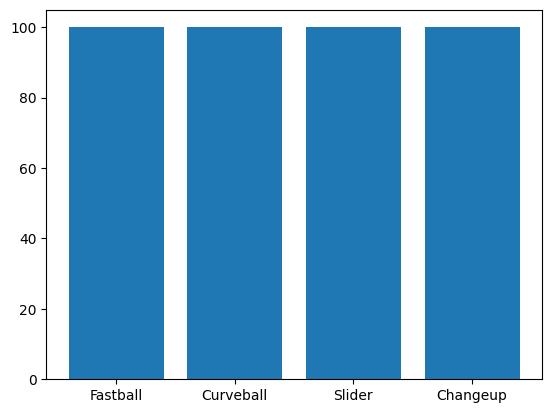

In [252]:
#creat a visualization of the mean of stuff+ for each pitch type 
plt.bar(['Fastball', 'Curveball', 'Slider', 'Changeup'], [dfb2['stuff+'].mean(), dcb2['stuff+'].mean(), dsl2['stuff+'].mean(), dch2['stuff+'].mean()])


In [253]:
#reccombine the dataframes
College_Final_Stuff = pd.concat([dfb2, dsl2, dcb2, dch2], ignore_index=True)

In [254]:
College_Final_Stuff

Pitcher PitcherTeam   TaggedPitchType       PitchCall  \
0     Peters, Treyson     WES_HIL  FourSeamFastBall      BallCalled   
1     Peters, Treyson     WES_HIL  FourSeamFastBall    StrikeCalled   
2     Peters, Treyson     WES_HIL  FourSeamFastBall  StrikeSwinging   
3     Peters, Treyson     WES_HIL  FourSeamFastBall      BallCalled   
4     Peters, Treyson     WES_HIL  FourSeamFastBall    StrikeCalled   
...               ...         ...               ...             ...   
8659     Slater, Owen     MIS_BEA          ChangeUp    StrikeCalled   
8660     Slater, Owen     MIS_BEA          ChangeUp      BallCalled   
8661     Slater, Owen     MIS_BEA          ChangeUp  StrikeSwinging   
8662     Slater, Owen     MIS_BEA          ChangeUp      BallCalled   
8663     Slater, Owen     MIS_BEA          ChangeUp          InPlay   

          PlayResult  RelSpeed     SpinRate  RelHeight  RelSide  Extension  \
0          Undefined  92.95122  2399.159367    6.52985  0.86183    6.04269   
1          Undefined  91.80022  2434.212248    6.44228  1.02252    6.12714   
2          Undefined  93.63045  2433.423257    6.51754  0.93130    5.89911   
3          Undefined  94.94424  2451.541620    6.53268  0.95526    6.10108   
4          Undefined  93.97190  2361.016863    6.49935  0.89254    6.11748   
...              ...       ...          ...        ...      ...        ...   
8659       Undefined  81.98077  2018.505043    4.95166  3.31262    6.47851   
8660       Undefined  84.33899  2029.489789    5.03304  3.30304    6.40139   
8661       Undefined  83.43245  2044.247320    4.96077  3.28268    6.53470   
8662       Undefined  82.05377  2106.639622    4.83521  3.26663    6.42538   
8663  FieldersChoice  84.55564  2122.716839    4.88437  3.31421    6.46090   

      ...  PlateLocHeight  PlateLocSide  ABS_Horizontal  ABS_RelSide  \
0     ...         3.64122      -0.73842         8.83453      0.86183   
1     ...         2.05916      -0.49380         1.97524      1.02252   
2     ...         3.03212      -0.76497         2.66225      0.93130   
3     ...         3.20007      -1.12561         7.97308      0.95526   
4     ...         2.36842      -1.28842         7.22823      0.89254   
...   ...             ...           ...             ...          ...   
8659  ...         1.68388       0.80283        19.07347      3.31262   
8660  ...         0.83184       0.38146        19.04257      3.30304   
8661  ...         1.80892       0.69714        17.56296      3.28268   
8662  ...         0.44357       0.55790        17.73080      3.26663   
8663  ...         2.67490       0.78129        19.65080      3.31421   

      differential_break  xWhiff_xg  xWhiff_rf  xWhiff_nn    xWhiff  \
0                9.69371   0.246556       0.26   0.810080  0.438879   
1               16.33883   0.041586       0.26   0.926140  0.409242   
2               16.12004   0.934622       0.82   0.920240  0.891621   
3               13.01953   0.204563       0.47   0.873193  0.515919   
4               11.79292   0.359644       0.38   0.845987  0.528544   
...                  ...        ...        ...        ...       ...   
8659            17.96760   0.129865       0.39   0.190834  0.236900   
8660            16.24009   0.153876       0.15   0.185400  0.163092   
8661            19.21753   0.962986       0.68   0.129421  0.590802   
8662            20.48261   0.135912       0.48   0.112549  0.242821   
8663            18.57879   0.070162       0.16   0.159497  0.129886   

          stuff+  
0     105.847682  
1      98.699960  
2     215.038901  
3     124.428040  
4     127.472872  
...          ...  
8659   60.139276  
8660   41.402455  
8661  149.980866  
8662   61.642326  
8663   32.972847  

[8664 rows x 22 columns]

In [255]:
College_Final_Stuff.to_csv('out.csv',index=False)